## Постановка задачи

На первой практике вам предстоит поработать с реальными данными об истории экспертиз рабочих программ дисциплин в ИТМО.

**Задача:** сделать краткое исследование данных и построить 3 графика двумя способами. Первый способ - самостоятельно. Второй - с активной помощью ChatGPT, Perplexity или [любого другого ИИ](https://theresanaiforthat.com/). Порядок реализации способов значения не имеет. Библиотеки можно использовать любые.

**Цель:** оценить качество помощи ИИ для аналитики. В конце обязательно сделайте текстовый вывод по результатам работы!

## Загрузка данных

Загрузим датасет в колаб, найти его также можно [по ссылке](https://drive.google.com/file/d/1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8/view?usp=share_link), если по какой-то причине у вас не работает gdown.

In [1]:
import pandas as pd

!gdown 1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8

Downloading...
From: https://drive.google.com/uc?id=1mJoAbyxf7vUU8_bVQvsahdW3HY8uz-V8
To: /content/exp_stats.csv
100% 925k/925k [00:00<00:00, 27.6MB/s]


Посмотрим на данные.

In [2]:
data = pd.read_csv("/content/exp_stats.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7657 entries, 0 to 7656
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   workprogram_id     7657 non-null   int64 
 1   user_count         7657 non-null   int64 
 2   expertise_status   7657 non-null   object
 3   expertise_counter  7657 non-null   int64 
 4   approval_date_y    7657 non-null   object
 5   title              7657 non-null   object
dtypes: int64(3), object(3)
memory usage: 359.0+ KB


Всего шесть столбцов, все без пропусков:
- `workprogram_id` - айди рабочей программы (РПД)
- `user_count` - сколько человек принимали участие в создании РПД
- `expertise_status` - на каком этапе экспертизы находится РПД (статус экспертизы: AC - одобрена, RE - на доработке, AR - в архиве, EX - на экспертизе, WK - в работе)
- `expertise_counter` - сколько раз РПД проходила экспертизу
- `approval_date` - день, когда РПД признали удовлетворяющей всем требованиям и разрешили ее реализовывать
- `title` - название дисциплины


In [14]:
data.head()

,workprogram_id,user_count,expertise_status,expertise_counter,approval_date_y,title,year
0,2626,4,AC,1,2022-05-06 12:23:17.924000+00:00,Философия,2022
1,8461,4,AC,1,2022-04-28 07:01:59.171000+00:00,Философия,2022
2,2627,3,AC,5,2021-08-31 18:51:19.142000+00:00,Введение в цифровую культуру и программирование,2021
3,2628,4,AC,0,2022-04-28 09:36:30.474000+00:00,Проектирование баз данных,2022
4,2631,4,AC,0,2022-04-28 10:06:31.165000+00:00,Современные вопросы информатики,2022


## Краткое исследование данных

В данных не слишком много столбцов и уже известно, что нет пустых ячеек. Теперь неплохо было бы погрузиться в них и ответить на 3 небольших вопроса:
1. Какой период охватывают данные в датасете?
2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце `user_count`. Или даты, которые сильно выбиваются из общего диапазона значений.
3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть `approval_date`. Или статус "одоберно", но РПД 0 раз проходила экспертизу.



In [6]:

data['approval_date_y'] = pd.to_datetime(data['approval_date_y'], errors='coerce', utc=True)


date_min = data['approval_date_y'].min()
date_max = data['approval_date_y'].max()


negative_user_count = data[data['user_count'] <= 0]

current_time = pd.Timestamp.now(tz='UTC')
unusual_dates = data[(data['approval_date_y'] < pd.Timestamp('2020-01-01', tz='UTC')) | (data['approval_date_y'] > current_time)]

illogical_work_status = data[(data['expertise_status'] == 'WK') & (data['approval_date_y'].notnull())]


illogical_approved_status = data[(data['expertise_status'] == 'AC') & (data['expertise_counter'] == 0)]



result = f"""
1. Период с {date_min} по {date_max}

2. Количество неположительных строк в "user_count": {negative_user_count.shape[0]}
Количество выбивающихся дат: {unusual_dates.shape[0]}

3. "В работе", но есть approval_date: {illogical_work_status.shape[0]}
"Одобрено", но 0 раз проходила экспертизу: {illogical_approved_status.shape[0]}
"""

print(result)



1. Период с 2021-04-21 09:32:30.614000+00:00 по 2023-04-17 09:35:20.872000+00:00

2. Количество неположительных строк в "user_count": 0
Количество выбивающихся дат: 0

3. "В работе", но есть approval_date: 4
"Одобрено", но 0 раз проходила экспертизу: 2919



Теперь ответьте на более интересные вопросы с использованием визуализаций.

### 1. Как распределяется количество редакторов рабочих программ на всем периоде наблюдений?

<ipython-input-8-823073ec537c>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_editor_counts = data.groupby(data['approval_date_y'].dt.to_period('M'))['user_count'].sum()


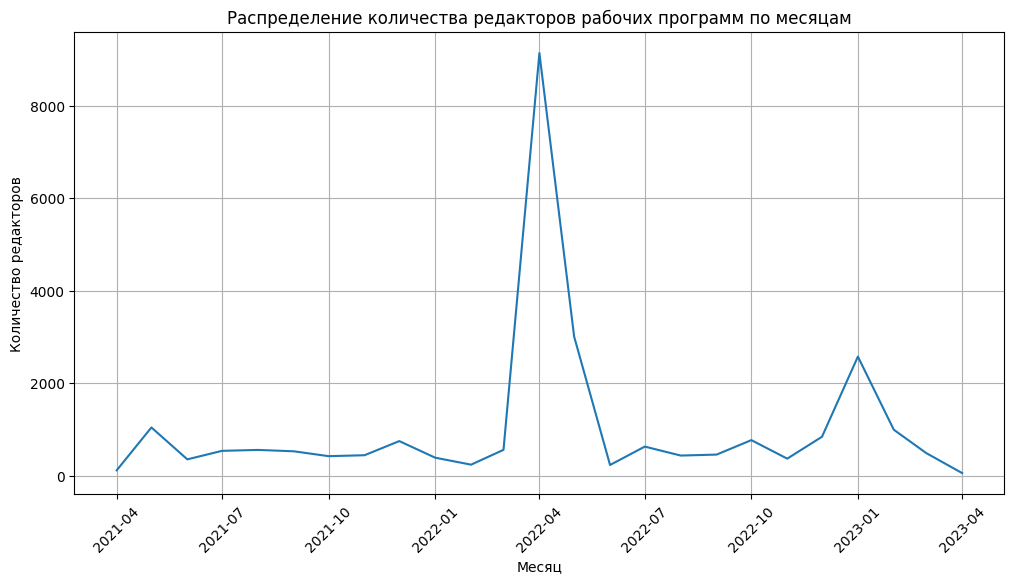

In [8]:
data['approval_date_y'] = pd.to_datetime(data['approval_date_y'])

monthly_editor_counts = data.groupby(data['approval_date_y'].dt.to_period('M'))['user_count'].sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_editor_counts.index.to_timestamp(), monthly_editor_counts.values)
plt.xlabel('Месяц')
plt.ylabel('Количество редакторов')
plt.title('Распределение количества редакторов рабочих программ по месяцам')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

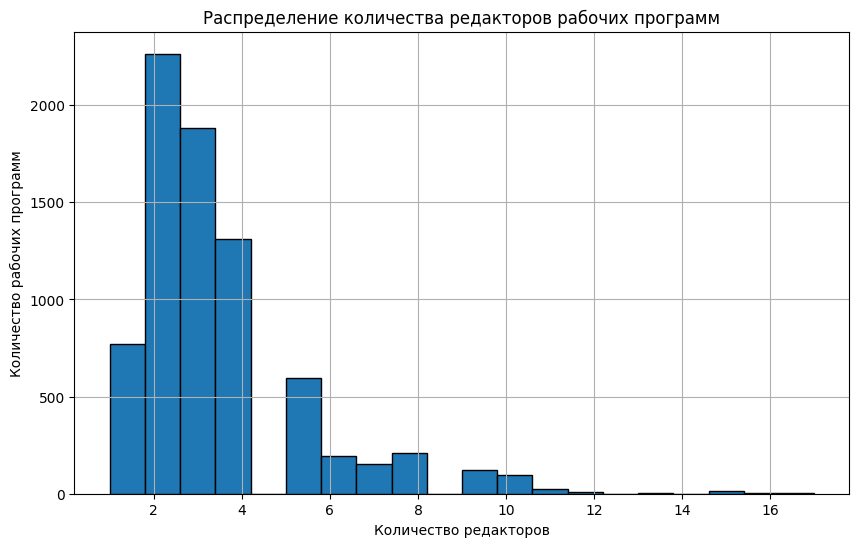

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(data['user_count'], bins=20, edgecolor='black')
plt.xlabel('Количество редакторов')
plt.ylabel('Количество рабочих программ')
plt.title('Распределение количества редакторов рабочих программ')
plt.grid(True)
plt.show()

### 2. Как со временем менялось среднее количество экспертиз РПД?

<ipython-input-10-e36ed10cab69>:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly_avg_expertise = data.groupby(data['approval_date_y'].dt.to_period('W'))['expertise_counter'].mean()


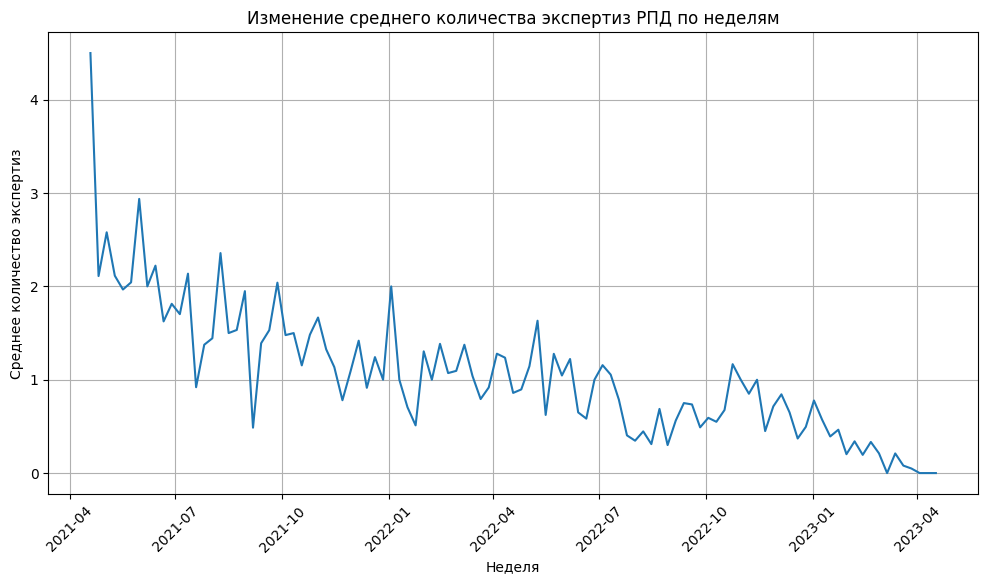

In [10]:
weekly_avg_expertise = data.groupby(data['approval_date_y'].dt.to_period('W'))['expertise_counter'].mean()

plt.figure(figsize=(12, 6))
plt.plot(weekly_avg_expertise.index.to_timestamp(), weekly_avg_expertise.values)
plt.xlabel('Неделя')
plt.ylabel('Среднее количество экспертиз')
plt.title('Изменение среднего количества экспертиз РПД по неделям')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### 3. Есть ли зависимость между датой и присвоением статуса "одобрено" (AC)?

<ipython-input-12-ecdae2f0a9a9>:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly_approved = data[data['expertise_status'] == 'AC'].groupby(data['approval_date_y'].dt.to_period('W'))['expertise_status'].count()


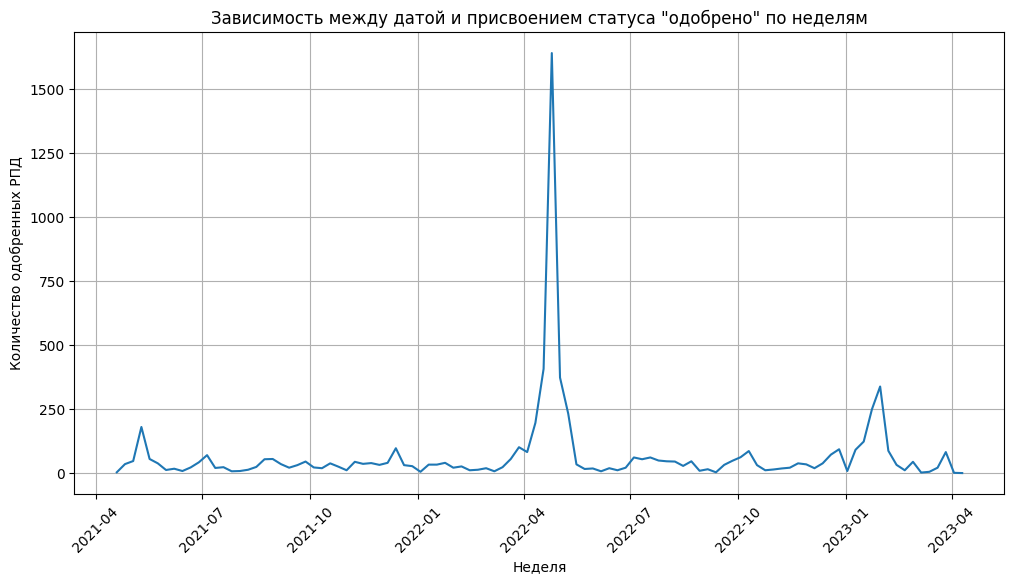

In [12]:
weekly_approved = data[data['expertise_status'] == 'AC'].groupby(data['approval_date_y'].dt.to_period('W'))['expertise_status'].count()

plt.figure(figsize=(12, 6))
plt.plot(weekly_approved.index.to_timestamp(), weekly_approved.values)
plt.xlabel('Неделя')
plt.ylabel('Количество одобренных РПД')
plt.title('Зависимость между датой и присвоением статуса "одобрено" по неделям')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Оцените результаты

В мае 2022 года наблюдался пик активности по всем показателям: как по количеству редакторов, так и по количеству экспертиз и одобренных программ. После этого активность снижается.

Снижение среднего количества экспертиз может говорить о завершении большого этапа работы, который был активен в начале периода.

## Аналитика с ИИ

Как модель я выбрал GPT-4о

## Краткое исследование данных

В данных не слишком много столбцов и уже известно, что нет пустых ячеек. Теперь неплохо было бы погрузиться в них и ответить на 3 небольших вопроса:
1. Какой период охватывают данные в датасете?
2. Есть ли в данных нетипичные значения? Например, неположительные числа в столбце `user_count`. Или даты, которые сильно выбиваются из общего диапазона значений.
3. Есть ли нелогичные значения в данных? Например, статус РПД "в работе", но есть `approval_date`. Или статус "одоберно", но РПД 0 раз проходила экспертизу.

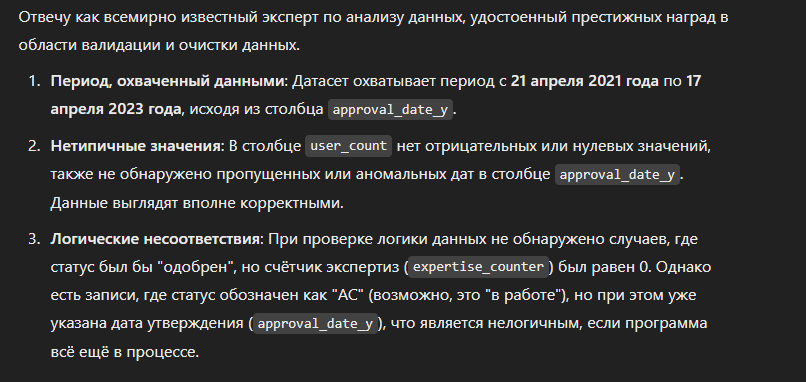

### 1. Как распределяется количество редакторов рабочих программ на всем периоде наблюдений?

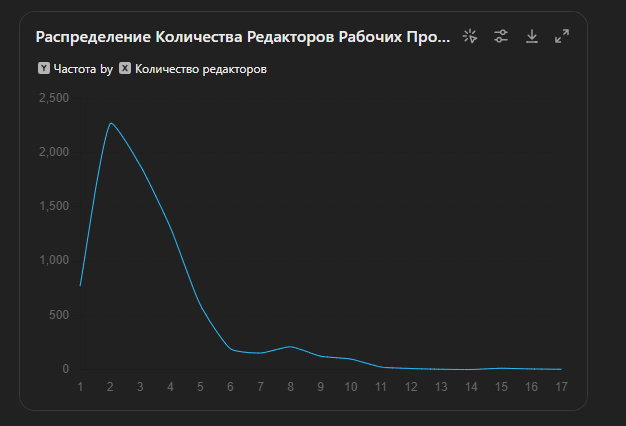

### 2. Как со временем менялось среднее количество экспертиз РПД?

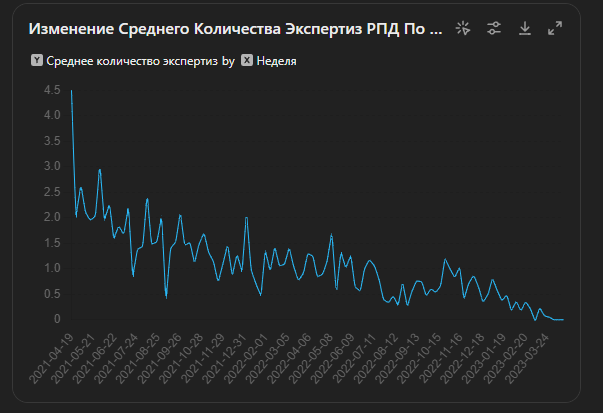

### 3. Есть ли зависимость между датой и присвоением статуса "одобрено" (AC)?

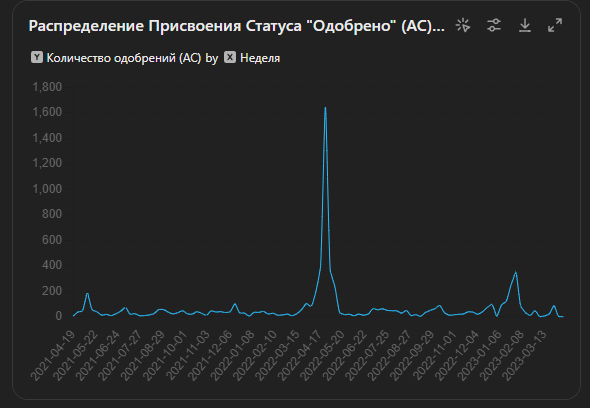

### Анализ

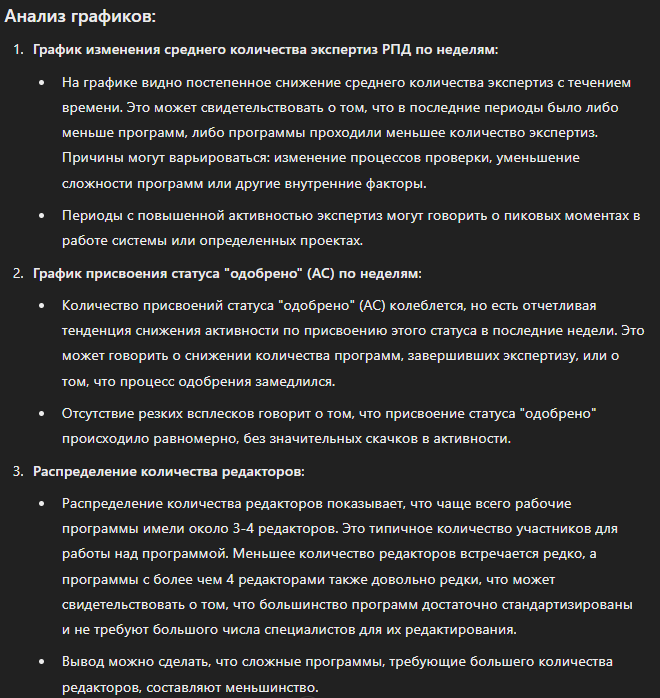

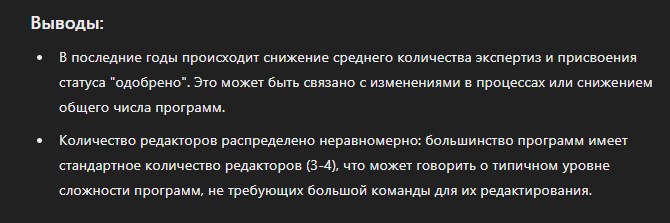

# Сравнение и вывод

Искусственный интеллект мощный инструмент позволяющий делать быстрее, но для правильного его использования нужны глубокие понимая как в использовании ИИ, так и в предметной области. Ни один график он сделал с первого раза без ошибок